<a href="https://colab.research.google.com/github/NILEG/TensorFlow/blob/main/009(Transfer_Learning_Inception_Model).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

####Loading Data

In [5]:
tf.keras.utils.get_file("dataset", origin="https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip", cache_dir="./", extract=True)

68606236/68606236 [==============================] - 0s 0us/step


'./datasets/dataset'

In [9]:
training_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255,
                                                             width_shift_range=0.2,
                                                             height_shift_range=0.2,
                                                             rotation_range=40,
                                                             horizontal_flip=True,
                                                             shear_range=0.2,
                                                             zoom_range=0.2)
training_data=training_generator.flow_from_directory("./datasets/cats_and_dogs_filtered/train/", target_size=(150,150), batch_size=20, class_mode="binary")


Found 2000 images belonging to 2 classes.


In [10]:
validation_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_data=validation_gen.flow_from_directory("./datasets/cats_and_dogs_filtered/validation/", target_size=(150,150), batch_size=20, class_mode="binary")


Found 1000 images belonging to 2 classes.


####Loading Inception Model

In [14]:
#pre-trained Weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-09-07 01:36:30--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.2.207, 2607:f8b0:4023:c0d::cf
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.2.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   201MB/s    in 0.4s    

2023-09-07 01:36:30 (201 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [16]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
inception_model=InceptionV3(include_top=False, weights=None, input_shape=(150,150,3))
#Loading Custom Weights
inception_model.load_weights("/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5")

for layer in inception_model.layers:
  layer.trainable=False

inception_model.summary()


Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [20]:
layer_output=inception_model.get_layer("mixed7")
layer.output_shape

(None, 3, 3, 2048)

In [21]:
#Creating our model
x=tf.keras.layers.Flatten()(layer_output.output)
x=tf.keras.layers.Dense(units=1024, activation="relu")(x)
x=tf.keras.layers.Dropout(0.2)(x)
x=tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

model=tf.keras.Model(inception_model.input, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [22]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(0.0001), loss="binary_crossentropy", metrics=["accuracy"])
history=model.fit(training_data, epochs=20, validation_data=validation_data)

Epoch 1/20
100/100 [==============================] - 30s 178ms/step - loss: 0.3642 - accuracy: 0.8480 - val_loss: 0.1302 - val_accuracy: 0.9500
Epoch 2/20
100/100 [==============================] - 17s 171ms/step - loss: 0.1966 - accuracy: 0.9205 - val_loss: 0.1059 - val_accuracy: 0.9550
Epoch 3/20
100/100 [==============================] - 19s 187ms/step - loss: 0.1820 - accuracy: 0.9345 - val_loss: 0.0998 - val_accuracy: 0.9630
Epoch 4/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1846 - accuracy: 0.9250 - val_loss: 0.0994 - val_accuracy: 0.9630
Epoch 5/20
100/100 [==============================] - 16s 156ms/step - loss: 0.1612 - accuracy: 0.9315 - val_loss: 0.0799 - val_accuracy: 0.9670
Epoch 6/20
100/100 [==============================] - 16s 157ms/step - loss: 0.1445 - accuracy: 0.9420 - val_loss: 0.1205 - val_accuracy: 0.9600
Epoch 7/20
100/100 [==============================] - 17s 171ms/step - loss: 0.1454 - accuracy: 0.9455 - val_loss: 0.1062 - val_ac

Text(0.5, 1.0, 'Accuracy')

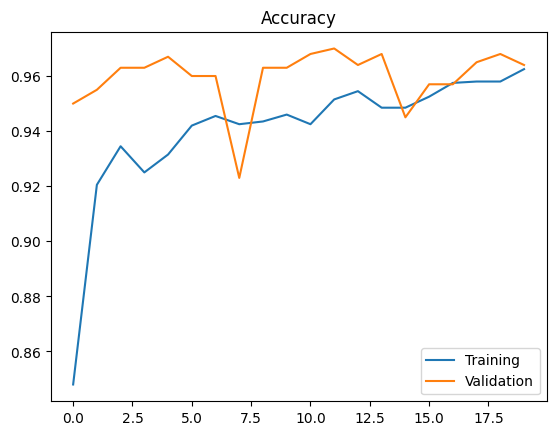

In [24]:
epochs=range(len(history.history["accuracy"]))
plt.plot(epochs, history.history["accuracy"], label="Training")
plt.plot(epochs, history.history["val_accuracy"], label="Validation")
plt.legend()
plt.title("Accuracy")
